In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import shutil
import numpy as np
import os

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pickle
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
if not os.path.exists('Discom_Drawal_Total.csv'):
  shutil.copy('/content/drive/MyDrive/Assignment_GNA/Discom_Drawal_Total.csv', '/content/Discom_Drawal_Total.csv')

In [5]:
## Load CSV with datetime index
df = pd.read_csv('Discom_Drawal_Total.csv', parse_dates=['TimeDesc'], index_col='TimeDesc')
df.index.freq = '15min'


In [6]:
## Rows and Columns
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 175296
Number of columns: 1


In [7]:
for col in df.columns:
  print(f'Column: {col}')

Column: Total


In [8]:
print('First 5 rows of the DataFrame:')
print(df.head().to_markdown(numalign='left', stralign='left'))

First 5 rows of the DataFrame:
| TimeDesc            | Total   |
|:--------------------|:--------|
| 2020-05-17 00:00:00 | 1180.13 |
| 2020-05-17 00:15:00 | 1148.01 |
| 2020-05-17 00:30:00 | 1132.86 |
| 2020-05-17 00:45:00 | 1106.42 |
| 2020-05-17 01:00:00 | 1103.59 |


In [9]:
print('\nLast 5 rows of the DataFrame:')
print(df.tail().to_markdown(numalign='left', stralign='left'))



Last 5 rows of the DataFrame:
| TimeDesc            | Total   |
|:--------------------|:--------|
| 2025-05-16 22:45:00 | 1048.11 |
| 2025-05-16 23:00:00 | 1062.11 |
| 2025-05-16 23:15:00 | 1046.11 |
| 2025-05-16 23:30:00 | 973.11  |
| 2025-05-16 23:45:00 | 973.11  |


In [10]:
print('Datatype summary:')
print(df.info())

Datatype summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175296 entries, 2020-05-17 00:00:00 to 2025-05-16 23:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Total   175296 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB
None


In [11]:
print('Statistical summary:')
print(df.describe().to_markdown(numalign='left', stralign='left'))

Statistical summary:
|       | Total   |
|:------|:--------|
| count | 175296  |
| mean  | 776.455 |
| std   | 409.592 |
| min   | 63.3    |
| 25%   | 443.368 |
| 50%   | 715.2   |
| 75%   | 1033.7  |
| max   | 2310.67 |


In [12]:
## Counting Missing Values
print("Missing Values per Column:")
print(df.isnull().sum().to_markdown(numalign='left', stralign='left'))

Missing Values per Column:
|       | 0   |
|:------|:----|
| Total | 0   |


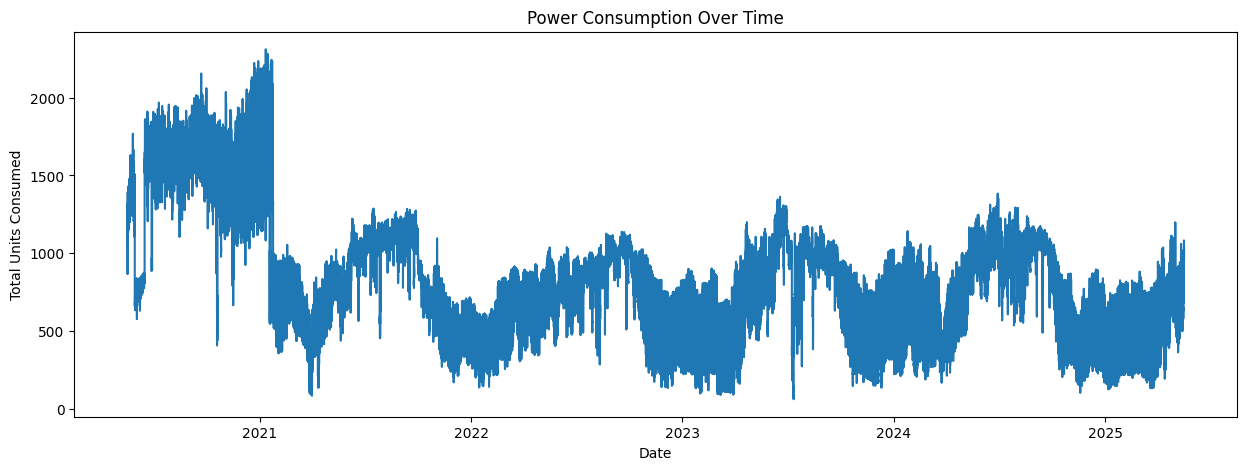

In [13]:

## Plot time series
plt.figure(figsize=(15,5))
plt.plot(df['Total'])
plt.title('Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Units Consumed')
plt.show()

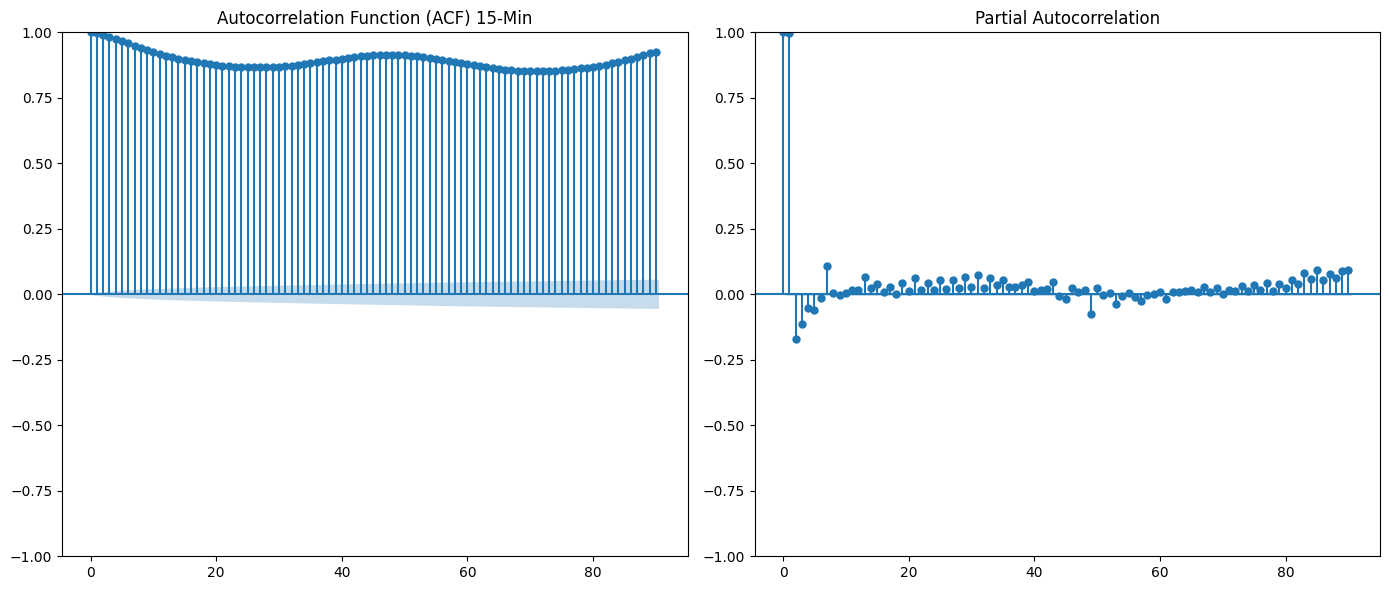

In [14]:
ts = df['Total']

plt.figure(figsize=(14, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(ts, lags=90, ax=plt.gca())
plt.title("Autocorrelation Function (ACF) 15-Min")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(ts, lags=90, ax=plt.gca(), method='ywm')  # 'ywm' is more stable for PACF

plt.tight_layout()
plt.show()

### Note:- WAVY Nature of ACF shows the Presence of Non-Stationarity (Seasonal or Cyclic Component) in 15min Time Period.

## Prophet Facebook

In [ ]:
!pip install prophet

In [ ]:
split_time = '2024-12-31 23:45:00'

train = df[:split_time]
test = df[split_time:]

df_prophet = train[['Total']].reset_index().rename(columns={
    'TimeDesc': 'ds',
    'Total': 'y'
})

print(f"Original df shape: {df.shape}")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"df_prophet shape: {df_prophet.shape}")

Original df shape: (175296, 1)
Train shape: (162240, 1)
Test shape: (13057, 1)
df_prophet shape: (162240, 2)


In [ ]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=4)
model.add_country_holidays(country_name='India')

model.fit(df_prophet)

/usr/local/lib/python3.11/dist-packages/holidays/countries/india.py:182: Warning: Requested Holidays are available only from 2001 to 2035.
  warnings.warn(warning_msg, Warning)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpijnhmztc/7zye2ii4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpijnhmztc/admbnqyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12770', 'data', 'file=/tmp/tmpijnhmztc/7zye2ii4.json', 'init=/tmp/tmpijnhmztc/admbnqyg.json', 'output', 'file=/tmp/tmpijnhmztc/prophet_modelqctf9dbk/prophet_model-20250520102612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:26:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test), freq='15min')
forecast = model.predict(future)
forecast_test = forecast.set_index('ds').loc[test.index]

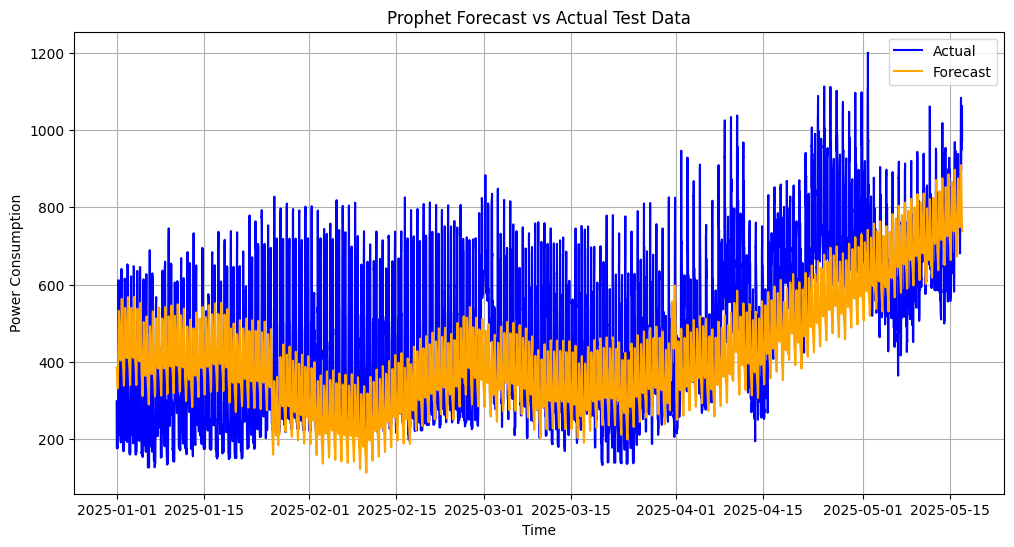

In [ ]:
## Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(test.index, test['Total'], label='Actual', color='blue')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Forecast', color='orange')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.title('Prophet Forecast vs Actual Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
start_date = '2025-01-01 00:00:00'
end_date = '2025-04-30 23:45:00'

##  actual test data for Jan-April 2025
actual_period = test.loc[start_date:end_date]['Total']

## forecast for the same period (set index for easy filtering)
forecast = forecast.set_index('ds')
predicted_period = forecast.loc[start_date:end_date]['yhat']

## Align indices to avoid mismatch
actual_period, predicted_period = actual_period.align(predicted_period, join='inner')

## Calculate metrics
mae = mean_absolute_error(actual_period, predicted_period)
rmse = np.sqrt(mean_squared_error(actual_period, predicted_period))
mape = np.mean(np.abs((actual_period - predicted_period) / actual_period)) * 100

print(f'Accuracy metrics from {start_date} to {end_date}:')
print(f'MAE  = {mae:.2f}')
print(f'RMSE = {rmse:.2f}')
print(f'MAPE = {mape:.2f}%')


Accuracy metrics from 2025-01-01 00:00:00 to 2025-04-30 23:45:00:
MAE  = 122.34
RMSE = 155.47
MAPE = 31.58%


##XGBOOST

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
# Load data
df = pd.read_csv("Discom_Drawal_Total.csv")
df['TimeDesc'] = pd.to_datetime(df['TimeDesc'])
df.set_index('TimeDesc', inplace=True)

# Keep only hourly level data
df_hourly = df[['Total']].copy()
df_hourly.dropna(inplace=True)


In [19]:
# Feature engineering for hourly data
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['day'] = df_hourly.index.day
df_hourly['is_weekend'] = df_hourly['dayofweek'].isin([5, 6]).astype(int)


In [20]:
# Add lag features (past 1 to 24 hours for short-term context, or more)
for lag in range(1, 25):  # Last 24 hours
    df_hourly[f'lag_{lag}'] = df_hourly['Total'].shift(lag)

df_hourly.dropna(inplace=True)

In [21]:
# Train/validation split
train = df_hourly[df_hourly.index <= '2024-12-31 23:00:00']
val = df_hourly[(df_hourly.index >= '2025-01-01 00:00:00') & (df_hourly.index <= '2025-04-30 23:00:00')]


In [22]:
features = [col for col in df_hourly.columns if col != 'Total']
X_train, y_train = train[features], train['Total']
X_val, y_val = val[features], val['Total']



In [23]:

# Train model
model = XGBRegressor(n_estimators=200, learning_rate=0.05)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
# Predict & evaluate
val_preds = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
mae = mean_absolute_error(y_val, val_preds)
mape = np.mean(np.abs((y_val - val_preds) / y_val)) * 100

print("📈 XGBoost Evaluation (Jan–Apr 2025):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


📈 XGBoost Evaluation (Jan–Apr 2025):
RMSE: 42.36
MAE: 23.87
MAPE: 5.68%


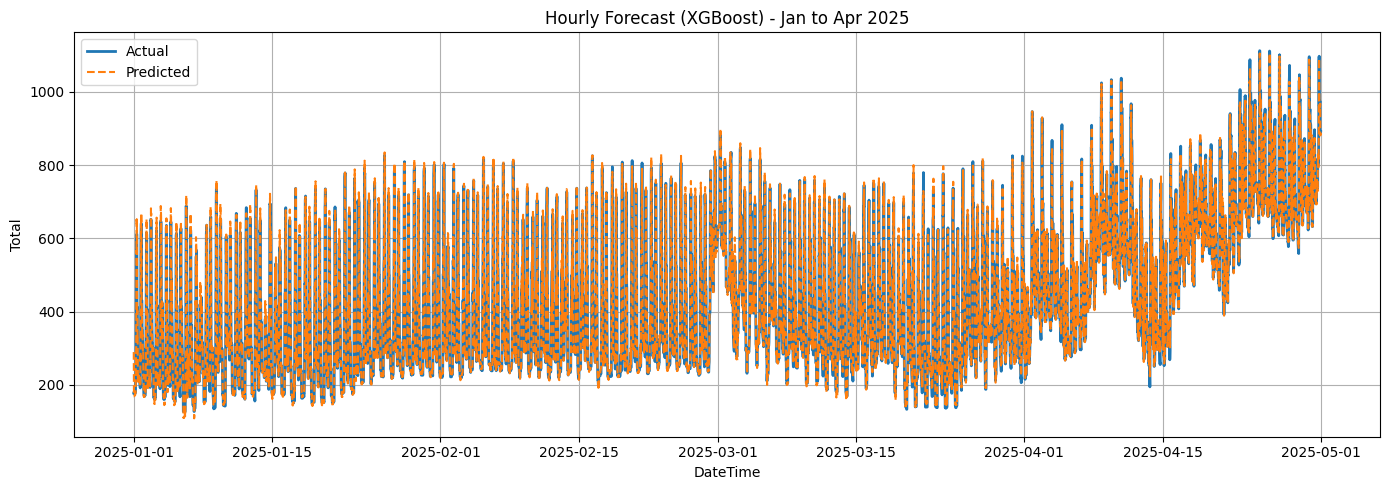

In [25]:
# Plot actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, val_preds, label='Predicted', linestyle='--')
plt.title('Hourly Forecast (XGBoost) - Jan to Apr 2025')
plt.xlabel('DateTime')
plt.ylabel('Total')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Forecast May–July 2025 (hourly)
future_dates = pd.date_range(start="2025-05-01 00:00:00", end="2025-07-31 23:00:00", freq='H')
forecast_df_recursive = df_hourly.copy()
forecast_values = []

for date in future_dates:
    forecast_df_recursive.loc[date, 'hour'] = date.hour
    forecast_df_recursive.loc[date, 'dayofweek'] = date.dayofweek
    forecast_df_recursive.loc[date, 'month'] = date.month
    forecast_df_recursive.loc[date, 'day'] = date.day
    forecast_df_recursive.loc[date, 'is_weekend'] = int(date.dayofweek in [5, 6])

    for lag in range(1, 25):
        prev_time = date - pd.Timedelta(hours=lag)
        if prev_time in forecast_df_recursive.index:
            forecast_df_recursive.loc[date, f'lag_{lag}'] = forecast_df_recursive.loc[prev_time, 'Total']
        else:
            forecast_df_recursive.loc[date, f'lag_{lag}'] = np.nan

    input_row = forecast_df_recursive.loc[date, features].values.reshape(1, -1)
    prediction = model.predict(input_row)[0]
    forecast_values.append(prediction)
    forecast_df_recursive.loc[date, 'Total'] = prediction


<ipython-input-26-4ced53b7622e>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start="2025-05-01 00:00:00", end="2025-07-31 23:00:00", freq='H')


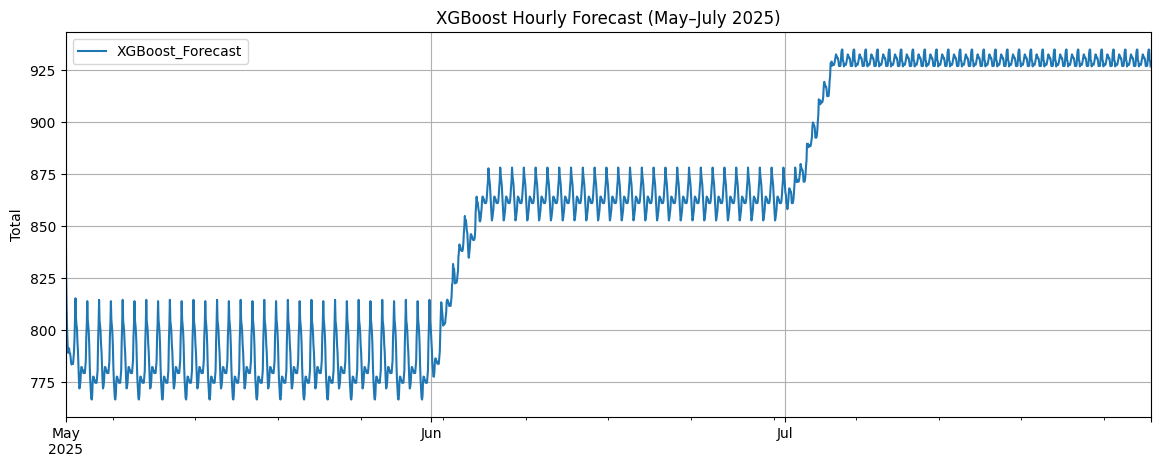

In [27]:
# Final forecast DataFrame
forecast_df = pd.DataFrame({'XGBoost_Forecast': forecast_values}, index=future_dates)

# Plot forecast
forecast_df.plot(title='XGBoost Hourly Forecast (May–July 2025)', figsize=(14, 5))
plt.grid(True)
plt.ylabel("Total")
plt.show()

In [28]:
is_forecasted_df = forecast_df.copy()
is_forecasted_df.to_csv('/content/drive/MyDrive/Assignment_GNA/XGBoost_Hourly_Forecast_May_July_2025.csv')